In [1]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense ,Dropout, Bidirectional
from keras.optimizers import Nadam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from neural_network_functions import *

 	(n_samples, n_timesteps, n_features):
	•	n_samples — количество образцов (примеров).
	•	n_timesteps — количество временных шагов (или последовательных значений).
	•	n_features — количество признаков (фич) для каждого временного шага.

In [15]:
n_timesteps = 15
n_features = 1
n_forecast = 10

In [16]:
df = pd.read_csv('dataset_days.csv', sep=',', index_col="time")
df.head()

Среднняя t  Минимальная t  Максимальная t  Суточная сумма осадков  \
time                                                                            
2019-05-24        13.6            8.9            17.5                     0.0   
2019-05-25        15.6           11.8            18.9                     0.3   
2019-05-26        18.1           14.3            23.6                     0.0   
2019-05-27        16.7           12.5            21.2                     0.0   
2019-05-28        22.0           15.9            28.4                     0.0   

            Глубина снега  Скорость ветра  Среднее давление hPa  \
time                                                              
2019-05-24            0.0             4.7                1012.7   
2019-05-25            0.0             4.6                1010.2   
2019-05-26            0.0             2.4                1004.7   
2019-05-27            0.0             4.7                1008.5   
2019-05-28            0.0             2.9                1014.1   

            Относительная влажность в %  
time                                     
2019-05-24                       64.125  
2019-05-25                       56.625  
2019-05-26                       62.375  
2019-05-27                       52.500  
2019-05-28                       48.250

In [17]:
dfs = df.dropna(subset=["Среднняя t"])
dfs = dfs.reset_index(drop=True)
temp = dfs.iloc[:,:1].values

In [18]:
scaler = MinMaxScaler(feature_range=(0,1))

In [19]:
train, test, size = create_train_test_data(temp, 70)

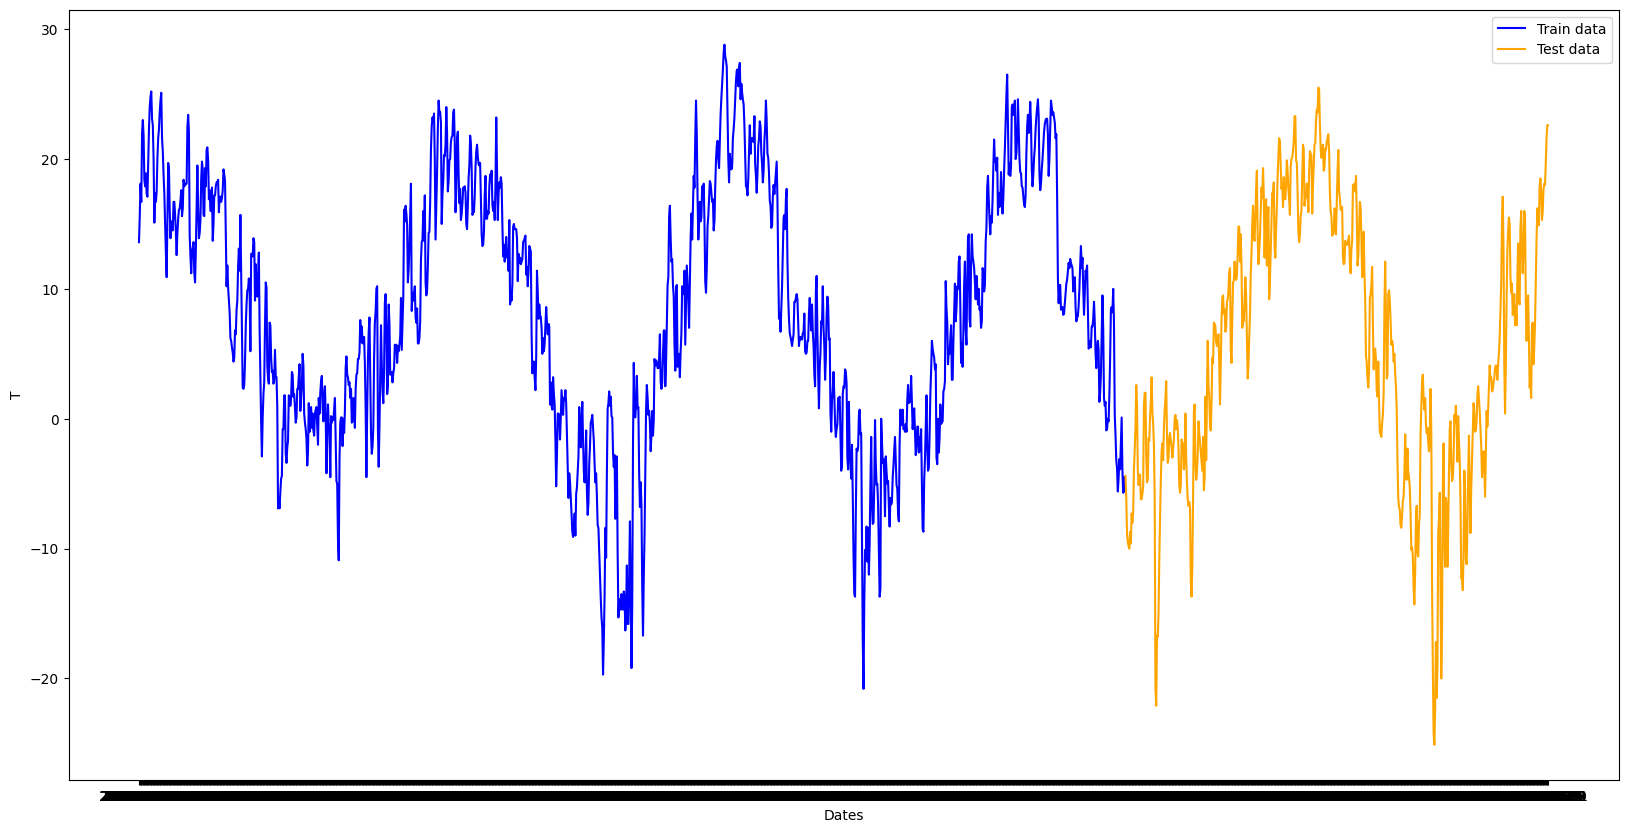

In [20]:
plt.figure(figsize=(20,10), dpi=100)
plt.xlabel('Dates')
plt.ylabel('T')
plt.plot(df.index[:size], train, 'blue', label='Train data')
plt.plot(df.index[size:], test, 'orange', label='Test data')
plt.legend()

In [21]:
train_scal = scaler.fit_transform(train)

In [22]:
x_train, y_train = create_data(train_scal, n_timesteps, n_forecast, n_features)

In [23]:
x_train.shape

(1260, 15, 1)

In [24]:
test_scal = scaler.transform(test)

In [25]:
test_scal.shape

(551, 1)

In [26]:
x_train, y_train = create_data(train_scal, n_timesteps, n_forecast, n_features)
x_test, y_test = create_data(test_scal, n_timesteps, n_forecast, n_features)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))
y_test = scaler.inverse_transform(y_test)

In [27]:
model = create_model(x_train=x_train,
                    n_forecast=n_forecast,
                    units=150,
                    n_features = n_features,
                    n_timesteps=n_timesteps)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 15, 300)        │       182,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 150)        │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 150)        │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 815,710 (3.11 MB)

 Trainable params: 815,710 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.fit(x_train, y_train, epochs=250, batch_size=32)

Epoch 1/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1103 - mae: 0.2581
Epoch 2/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0168 - mae: 0.1034
Epoch 3/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0152 - mae: 0.0968
Epoch 4/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0150 - mae: 0.0967
Epoch 5/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0131 - mae: 0.0907
Epoch 6/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0131 - mae: 0.0905
Epoch 7/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0127 - mae: 0.0888
Epoch 8/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0132 - mae: 0.0914
Epoch 9/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121 - mae: 0.0867
Epoch 10/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0117 - mae: 0.0852
Epoch 11/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0117 - mae: 0.0846
Epoch 12/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0107 - mae: 0.0810
Epoch 13/250
40/40 ━━━━━━

In [29]:
predict = model.predict(x_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [30]:
predict = np.reshape(predict, (predict.shape[0], predict.shape[1]))
predict = scaler.inverse_transform(predict)

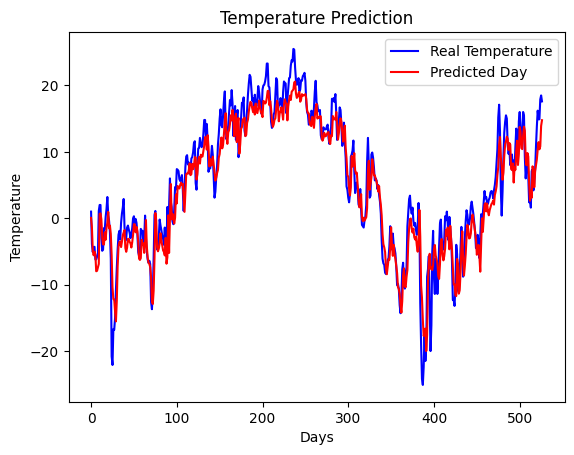

In [35]:
plt.plot(y_test[:, 0], color='blue', label='Real Temperature')

plt.plot(predict[:, 0], color='red', label=f'Predicted Day')

plt.title('Temperature Prediction')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [33]:
for i in range(n_forecast):
    mae_day = np.mean(np.abs(y_test[:, i] - predict[:, i]))
    print(f'MAE for Day {i+1}: {mae_day}')

MAE for Day 1: 2.424701902075923
MAE for Day 2: 3.2474917498560343
MAE for Day 3: 3.7207837864502107
MAE for Day 4: 3.9226476788577362
MAE for Day 5: 4.098286497893352
MAE for Day 6: 4.278685497391821
MAE for Day 7: 4.473470639670709
MAE for Day 8: 4.62329541189027
MAE for Day 9: 4.712887871514235
MAE for Day 10: 4.820527391540032
